Here I will try out the matrix factorisation algorythms. For this I will use the [Surprize Python package](https://surprise.readthedocs.io/). 

First I will try out the In package Movielens datasets, as per the tutorial in the package website.

In [30]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
# import os
from surprise import BaselineOnly, Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection.split import LeaveOneOut
from collections import defaultdict


In [21]:
# column_names = ['userId', 'movieId', 'rating', 'timestamp']

# data_100k = pd.read_csv('../ml-100k/u.ratings', sep="\t", names=column_names)

# reader = Reader(rating_scale=(1, 5))

# subset_test = data_100k[['userId', 'movieId', 'rating']]

# _100k_data = Dataset.load_from_df(subset_test, reader)

# print(_100k_data)

In [22]:

np.random.seed(42)

column_names = ['userId', 'movieId', 'rating', 'timestamp']

ratings = pd.read_csv('../ml-100k/u.data', sep='\t', names=column_names)

reader = Reader(rating_scale=(1, 5))

subset = ratings[['userId', 'movieId', 'rating']]
subset = subset.iloc[1:]
subset["rating"] = subset["rating"].astype(float)

custom_data = Dataset.load_from_df(subset, reader)

print(custom_data)

In [23]:
# movie_data_column_names = ['movieId', 'item_title', 'release_date', 'release_date_2', "url", "IMDb URL" , "unknown" , "Action" , "Adventure" , "Animation", 
#                             "Children's" | "Comedy" | Crime | Documentary | Drama | Fantasy 

movies = pd.read_csv('../ml-100k/u.item', sep='|',  encoding='ISO-8859-1')
movies = movies.iloc[:, 0:2]
movies.columns = ['movieId', 'item_title']

print(movies)

      movieId                                         item_title
0           2                                   GoldenEye (1995)
1           3                                  Four Rooms (1995)
2           4                                  Get Shorty (1995)
3           5                                     Copycat (1995)
4           6  Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...       ...                                                ...
1676     1678                                  Mat' i syn (1997)
1677     1679                                   B. Monkey (1998)
1678     1680                               Sliding Doors (1998)
1679     1681                                You So Crazy (1994)
1680     1682          Scream of Stone (Schrei aus Stein) (1991)

[1681 rows x 2 columns]


In [24]:
# Train-test split
trainset, testset = train_test_split(custom_data, test_size=0.2)

# Train the SVD model
algo = SVD()
algo.fit(trainset)

Use SVD model to recommend movies for new users (people who have rated at least 10 movies) and based on that, predict what other movies they would likely enjoy. 

First I will do a dummy run through as a proof of concept

In [25]:


# Predict for a new user
# Suppose you have userId = 12345 who rated 10 movies
# Now predict ratings for movies they have NOT rated
all_movie_ids = ratings['movieId'].unique()
rated_movies = ratings[ratings['userId'] == 12345]['movieId'].tolist()
print(f"User: {rated_movies}")
print(f"User movies: {rated_movies}")

movies_to_predict = [movie for movie in all_movie_ids if movie not in rated_movies]

# Make predictions
predictions = []
for movie_id in movies_to_predict:
    pred = algo.predict(12345, movie_id)
    predictions.append((movie_id, pred.est))

# Sort predictions by estimated rating
predictions.sort(key=lambda x: x[1], reverse=True)

# Recommend top 10 movies
top_10 = predictions[:10]

for index, (integer_value, float_value) in enumerate(top_10):
    movie_title = movies.loc[integer_value, 'item_title']
    print(f"Position: {index}, Movie: {movie_title}, Predicted rating: {float_value}")
    

User: []
User movies: []
Position: 0, Movie: Delicatessen (1991), Predicted rating: 4.581708391298929
Position: 1, Movie: Paradise Lost: The Child Murders at Robin Hood Hills (1996), Predicted rating: 4.580530269390127
Position: 2, Movie: While You Were Sleeping (1995), Predicted rating: 4.573436263451
Position: 3, Movie: My Fair Lady (1964), Predicted rating: 4.552318344422202
Position: 4, Movie: Kingpin (1996), Predicted rating: 4.528909891186977
Position: 5, Movie: Boot, Das (1981), Predicted rating: 4.455029958631393
Position: 6, Movie: Postino, Il (1994), Predicted rating: 4.44071242515515
Position: 7, Movie: Cold Comfort Farm (1995), Predicted rating: 4.417475584056654
Position: 8, Movie: Meet Me in St. Louis (1944), Predicted rating: 4.412549289235366
Position: 9, Movie: Some Like It Hot (1959), Predicted rating: 4.406388337899761


Next, I will try with a known user, with at least 20 ratings. I will use userId 42, who has more than 20 ratings in the dataset. I will randomly select 10 of those ratings to simulate the "user with 10 ratings" situation. Then, I will use the SVD model to predict ratings for the remaining movies that the user has not yet rated. Next, I will recommend the top 10 movies based on the predicted ratings. Since we already know the users full ratings, we can the test our predictions against the he actual ratings. This will give us an idea of how accurate our recommendations are. 

###RMSE (Root Mean Squared Error):
•	RMSE measures how close the predicted ratings are to the real ratings.
•	It's a "regression" metric.
•	Example:
o	True rating = 4.0
o	Predicted rating = 3.5
o	Error = 0.5
•	RMSE gives you the "average size of the errors" across many predictions.
•	Lower RMSE is better (closer to real ratings).


In [26]:
# Simulate the "user with 10 ratings" situation
userId = 42
user_ratings = ratings[ratings['userId'] == userId]

print(f"User {userId} has rated {len(user_ratings)} movies.")
# Only if the user has enough ratings
if len(user_ratings) >= 20:
    # Randomly select 10 known ratings from simualted user
    known_ratings = user_ratings.sample(10)
    known_movies = known_ratings['movieId'].tolist()
    print(f"Known Movies: {known_movies}")
    
    # The rest are the hidden "test" ratings
    hidden_ratings = user_ratings[~user_ratings['movieId'].isin(known_movies)]
    hidden_ratings = hidden_ratings.sort_values(by="rating")
    print(f"Hidden Movies: {hidden_ratings}")

    # Now, imagine training the model ONLY with the 10 ratings for this user.
    # Since we can't re-train, we simulate by making predictions anyway.
    
    # Make predictions for the hidden movies
    testset_user = [
        (userId, movie_id, true_rating) for movie_id, true_rating in zip(
            hidden_ratings['movieId'], 
            hidden_ratings['rating']
            )]
    print(f"testset user {testset_user}")
    predictions = algo.test(testset_user)

    # Calculate RMSE or other metrics
    rmse = accuracy.rmse(predictions)
    print(f"RMSE for user {userId} with only 10 ratings: {rmse}")


User 42 has rated 183 movies.
Known Movies: [1045, 142, 97, 655, 234, 939, 720, 443, 685, 521]
Hidden Movies:        userId  movieId  rating  timestamp
19661      42      276       1  881105405
18428      42      413       1  881106072
70653      42     1048       1  881106220
73843      42      111       1  881105931
70257      42      595       1  881106582
...       ...      ...     ...        ...
15383      42      215       5  881107413
15339      42      496       5  881107718
15338      42      194       5  881107329
20548      42        1       5  881105633
18663      42       77       5  881108684

[173 rows x 4 columns]
testset user [(42, 276, 1), (42, 413, 1), (42, 1048, 1), (42, 111, 1), (42, 595, 1), (42, 219, 1), (42, 834, 1), (42, 1043, 2), (42, 679, 2), (42, 559, 2), (42, 43, 2), (42, 131, 2), (42, 451, 2), (42, 627, 2), (42, 433, 2), (42, 658, 2), (42, 367, 2), (42, 462, 2), (42, 977, 2), (42, 953, 2), (42, 175, 2), (42, 103, 3), (42, 428, 3), (42, 826, 3), (42, 409, 3

I have just performed a test on one user out of the dataset where the user has only predicted 10 movies. The RMSE for this user is 0.7659. This means that the model's predictions are, on average, 0.7659 units away from the actual ratings. This is a relatively high error, which suggests that the model may not be very accurate for this user. However, it's important to note that this is just one user and the model may perform better for other users.

Next, we will perform the same prediction test with a larger sample of users. 

In [27]:
# Find users with at least 20 ratings
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index.tolist()

print(f"Eligible users {len(eligible_users)}")

# We'll sample (say) 100 users to test
sampled_users = random.sample(eligible_users, 100)

user_rmse_scores = []

for userId in sampled_users:
    user_ratings = ratings[ratings['userId'] == userId]

    # Select 10 known ratings
    known_ratings = user_ratings.sample(10, random_state=42)
    known_movies = known_ratings['movieId'].tolist()
    
    # Hidden ratings
    hidden_ratings = user_ratings[~user_ratings['movieId'].isin(known_movies)]
    
    if hidden_ratings.empty:
        continue  # Skip if no hidden ratings (shouldn't happen but just in case)

    # Create a testset for this user: predict for hidden movies
    testset_user = [(userId, movieId, true_rating) for movieId, true_rating in zip(hidden_ratings['movieId'], hidden_ratings['rating'])]

    predictions = algo.test(testset_user)
    
    # Calculate RMSE for this user
    rmse = accuracy.rmse(predictions, verbose=False)
    user_rmse_scores.append(rmse)

# Now calculate overall average RMSE
average_rmse = np.mean(user_rmse_scores)
print(f"Average RMSE across {len(user_rmse_scores)} users with only 10 ratings: {average_rmse}")


Eligible users 943
Average RMSE across 100 users with only 10 ratings: 0.7536262265420391


The RMSE across 100 users is with only 10 ratings is 0.7341. The error has decreased ed slightly compared to the previous test with a single user. This suggests that the model is more accurate when predicting for a larger sample of users. However, it's important to note that this is still a relatively high error, which suggests that the model may not be very accurate for users with only a few ratings.

Next, we can test if the RMSE goes down to a lower value when we increase the number of ratings to 20. I will also test with other amounts of ratings to see if there is a pattern.

In [28]:
# Find users with at least 50 ratings
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 50].index.tolist()

# Sample 100 users
sampled_users = random.sample(eligible_users, 100)

# Different number of known ratings to test
known_ratings_list = [5, 10, 20, 30, 40]

rmse_results = []

for num_known in known_ratings_list:
    user_rmse_scores = []
    
    for userId in sampled_users:
        user_ratings = ratings[ratings['userId'] == userId]
        
        if len(user_ratings) < num_known + 5:  # Make sure there's enough hidden ratings
            continue
        
        known_ratings = user_ratings.sample(num_known, random_state=42)
        known_movies = known_ratings['movieId'].tolist()
        
        hidden_ratings = user_ratings[~user_ratings['movieId'].isin(known_movies)]
        
        if hidden_ratings.empty:
            continue

        testset_user = [(userId, movie_id, true_rating) for movie_id, true_rating in zip(hidden_ratings['movieId'], hidden_ratings['rating'])]

        predictions = algo.test(testset_user)
        
        rmse = accuracy.rmse(predictions, verbose=False)
        user_rmse_scores.append(rmse)
    
    # Average RMSE for this number of known ratings
    avg_rmse = np.mean(user_rmse_scores)
    rmse_results.append(avg_rmse)
    print(f"Known ratings: {num_known} -> Average RMSE: {avg_rmse:.4f}")




Known ratings: 5 -> Average RMSE: 0.7242
Known ratings: 10 -> Average RMSE: 0.7275
Known ratings: 20 -> Average RMSE: 0.7278
Known ratings: 30 -> Average RMSE: 0.7232
Known ratings: 40 -> Average RMSE: 0.7207


Plot the above findings 

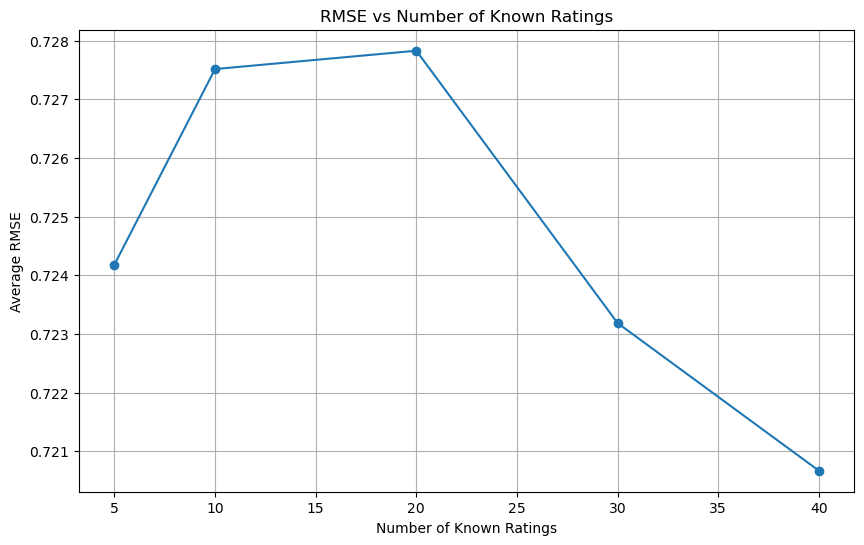

In [29]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(known_ratings_list, rmse_results, marker='o')
plt.title('RMSE vs Number of Known Ratings')
plt.xlabel('Number of Known Ratings')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.show()

this is a very interesting chart, as it shows that error does not go down that much, even when the user has rated as many as 40 movies, when compared to a user who has only rated 5 movies 

Next I will create a svd recommender that tests the models precision@k rather than RMSE

In [31]:
# Get all users
all_users = ratings['userId'].unique()

# Sample 100 users who have rated a lot
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index.tolist()
sampled_users = random.sample(eligible_users, 100)

k = 10  # Top 10 recommendations

precision_scores = []

for user_id in sampled_users:
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Simulate that we only know a few ratings
    known_ratings = user_ratings.sample(10, random_state=42)
    known_movies = set(known_ratings['movieId'])
    
    # Candidate movies: everything except what user has already rated
    all_movies = set(ratings['movieId'].unique())
    unseen_movies = list(all_movies - known_movies)
    
    # Predict ratings for unseen movies
    predictions = [ (movie_id, algo.predict(user_id, movie_id).est) for movie_id in unseen_movies ]
    
    # Sort movies by predicted rating, highest first
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Take top-k movies
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    
    # What are the movies the user *actually liked* (rated 4.0 or higher)?
    true_liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
    
    if not true_liked_movies:
        continue  # Skip user if they have no strong likes

    # Calculate Precision@K
    relevant_in_top_k = sum([1 for movie_id in top_k_movies if movie_id in true_liked_movies])
    precision_at_k = relevant_in_top_k / k
    precision_scores.append(precision_at_k)

# Final Precision@K
average_precision = np.mean(precision_scores)
print(f"Average Precision@{k}: {average_precision:.4f}")


Average Precision@10: 0.2830


next we will calculate the following metrics: Precision@k, Recall@K, NDCG@K

In [32]:
# Get all users
all_users = ratings['userId'].unique()

# Sample 100 users who have rated enough
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index.tolist()
sampled_users = random.sample(eligible_users, 100)

k = 10  # Top 10 recommendations

precision_scores = []
recall_scores = []
ndcg_scores = []

for user_id in sampled_users:
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Simulate 10 known ratings
    known_ratings = user_ratings.sample(10, random_state=42)
    known_movies = set(known_ratings['movieId'])
    
    # Candidate movies: unseen
    all_movies = set(ratings['movieId'].unique())
    unseen_movies = list(all_movies - known_movies)
    
    # Predict ratings for unseen movies
    predictions = [ (movie_id, algo.predict(user_id, movie_id).est) for movie_id in unseen_movies ]
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Top-K recommended movies
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    
    # Movies the user actually liked (rating >= 4)
    true_liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
    
    if not true_liked_movies:
        continue  # Skip user if no strong likes
    
    # --- Calculate Precision@K ---
    relevant_in_top_k = sum([1 for movie_id in top_k_movies if movie_id in true_liked_movies])
    precision_at_k = relevant_in_top_k / k
    precision_scores.append(precision_at_k)
    
    # --- Calculate Recall@K ---
    recall_at_k = relevant_in_top_k / len(true_liked_movies)
    recall_scores.append(recall_at_k)
    
    # --- Calculate NDCG@K ---
    dcg = 0.0
    for idx, movie_id in enumerate(top_k_movies):
        if movie_id in true_liked_movies:
            dcg += 1.0 / np.log2(idx + 2)  # +2 because index starts from 0
    
    # Ideal DCG (IDCG)
    ideal_relevant = min(len(true_liked_movies), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_relevant))
    
    ndcg = dcg / idcg if idcg > 0 else 0.0
    ndcg_scores.append(ndcg)

# Final results
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_ndcg = np.mean(ndcg_scores)

print(f"Average Precision@{k}: {average_precision:.4f}")
print(f"Average Recall@{k}: {average_recall:.4f}")
print(f"Average NDCG@{k}: {average_ndcg:.4f}")


Average Precision@10: 0.3040
Average Recall@10: 0.0535
Average NDCG@10: 0.3203


 
1. Precision@K (quick reminder)
Imagine you recommend 5 movies (K=5).
Out of those, the user actually likes 3 movies.
•	Precision@5 = (3 liked) / (5 recommended) = 0.6
It measures:
"Out of what I recommended, how much was good?"
 
2. Recall@K
Now imagine the user loves 10 movies in total (out of the full catalog), but you only recommended 5 movies.
You recommended 3 of those 10 favorite movies.
•	Recall@5 = (3 liked) / (10 possible liked) = 0.3
So recall measures:
"Out of all the things the user could have liked, how many did I show them?"
In simple words:
•	Precision asks: "Was what I recommended good?"
•	Recall asks: "Did I miss anything the user would have liked?"
 
3. NDCG@K (Normalized Discounted Cumulative Gain)
This is a little fancier, but extremely important for ranking.
NDCG@K measures:
•	Not just what you recommended,
•	but whether you ranked the best stuff at the top.
Because in real apps (Netflix, Amazon, Spotify...),
users only see the first few recommendations.
If you recommend their favorite movie at position #1, that's awesome.
If it's hidden at position #10, that's worse.
NDCG gives bonus points for ranking good movies higher.


Now that we have established some new metrics, we will plot the differences in metrics acorss different initial ratings

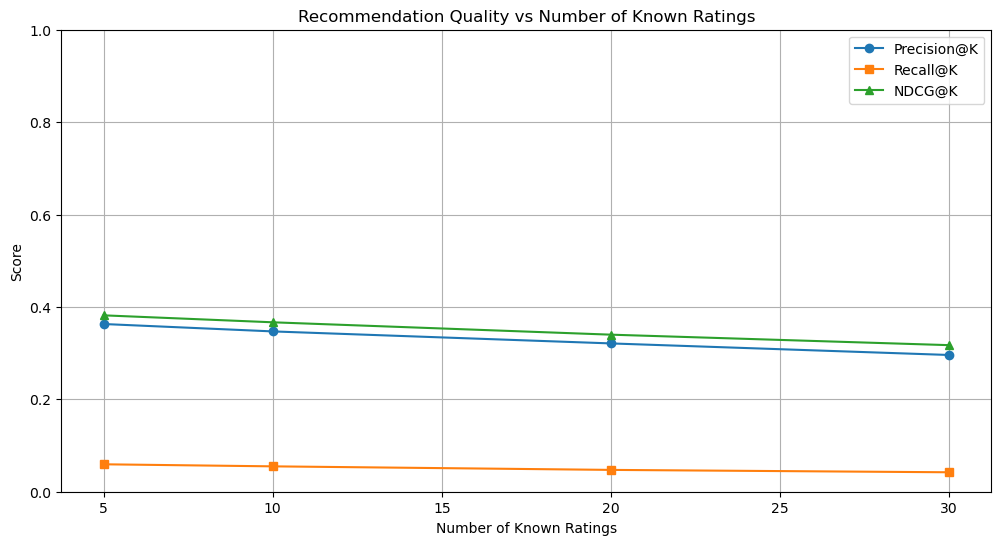

In [33]:
# Get all users
user_rating_counts = ratings['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 30].index.tolist()
sampled_users = random.sample(eligible_users, 100)  # Pick users with at least 30 ratings

k = 10  # Top 10 recommendations

# Different numbers of known ratings to test
known_ratings_list = [5, 10, 20, 30]

# To store results
precision_at_k_all = []
recall_at_k_all = []
ndcg_at_k_all = []

for known_ratings_size in known_ratings_list:
    precision_scores = []
    recall_scores = []
    ndcg_scores = []
    
    for user_id in sampled_users:
        user_ratings = ratings[ratings['userId'] == user_id]
        
        if len(user_ratings) < known_ratings_size + 1:
            continue  # Skip if not enough ratings
        
        known_ratings = user_ratings.sample(known_ratings_size, random_state=42)
        known_movies = set(known_ratings['movieId'])
        
        all_movies = set(ratings['movieId'].unique())
        unseen_movies = list(all_movies - known_movies)
        
        predictions = [ (movie_id, algo.predict(user_id, movie_id).est) for movie_id in unseen_movies ]
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
        
        true_liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
        
        if not true_liked_movies:
            continue
        
        relevant_in_top_k = sum([1 for movie_id in top_k_movies if movie_id in true_liked_movies])
        
        # Precision@K
        precision_at_k = relevant_in_top_k / k
        precision_scores.append(precision_at_k)
        
        # Recall@K
        recall_at_k = relevant_in_top_k / len(true_liked_movies)
        recall_scores.append(recall_at_k)
        
        # NDCG@K
        dcg = 0.0
        for idx, movie_id in enumerate(top_k_movies):
            if movie_id in true_liked_movies:
                dcg += 1.0 / np.log2(idx + 2)
        
        ideal_relevant = min(len(true_liked_movies), k)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_relevant))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)
    
    # Average over users
    precision_at_k_all.append(np.mean(precision_scores))
    recall_at_k_all.append(np.mean(recall_scores))
    ndcg_at_k_all.append(np.mean(ndcg_scores))

# --- Now, plot everything ---

plt.figure(figsize=(12, 6))

plt.plot(known_ratings_list, precision_at_k_all, marker='o', label='Precision@K')
plt.plot(known_ratings_list, recall_at_k_all, marker='s', label='Recall@K')
plt.plot(known_ratings_list, ndcg_at_k_all, marker='^', label='NDCG@K')

plt.title('Recommendation Quality vs Number of Known Ratings')
plt.xlabel('Number of Known Ratings')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


We can see that acorss all metrics, that more ratings do not give much better results.  